In [3015]:
import numpy as np
import math
import networkx as nx
import random

import matplotlib.pyplot as plt

In [3016]:
class Tank():
    def __init__(self, tank_id, current_load, max_load, consumption_rate, n_discrete_load_levels):
        self.id = tank_id
        self.load = current_load
        self.max_load = max_load
        self.rate = consumption_rate
        self.levels = np.linspace(0,self.max_load, n_discrete_load_levels)
   
    def fill(self):
        self.load = self.max_load    
        
    def partial_fill(self, fill_percentage):
        self.load = self.load + self.max_load * fill_percentage
    
    def tank_extra_capacity(self):
        return(self.max_load - self.load)
       
    def is_empty(self):
        if self.load <= 0:
            return(True)
        else:
            return(False)
       
    def consume(self):
        self.load = self.load - self.rate
       
        

In [3017]:
class Truck():
    def __init__(self, truck_id, current_load, max_load, current_position, load_fractions_deliverable,
                n_discrete_load_levels):
        self.id = truck_id
        self.load = current_load
        self.max_load = max_load
        self.pos = current_position
        self.fractions = load_fractions_deliverable
        self.levels = np.linspace(0,self.max_load, n_discrete_load_levels)
     
    def fill(self):
        self.load = self.max_load
        
    def deliver(self, fraction_id: int):
        self.load = self.load - self.fractions[fraction_id] * self.max_load
    
    def possible_delivery_quantities(self, tank_extra_capacity):
        all_delivery_quantities = self.load * self.fractions
        return(all_delivery_quantities[ all_delivery_quantities <= tank_extra_capacity].astype(list))
 

In [3018]:
class System():
    def __init__(self, tanks, trucks, adjacency_matrix, weights_matrix):
        self.tanks = tanks
        self.trucks = trucks
        self.graph = adjacency_matrix
        self.weights = weights_matrix
        self.k = len(trucks)
        self.n = len(tanks)
        self.s = self.state()
        self.ds = self.discrete_state()
        
        self.tanks_id = self.tank_ids()
        self.trucks_id = self.truck_ids()
        self.tanks_max_load = self.tank_max_loads()
        self.trucks_max_load = self.truck_max_loads()
        self.tanks_level = self.tank_levels()
        self.trucks_level = self.truck_levels()
        
        #
        self.actions_dim = self.n * self.k
        self.states_dim = self.n_states()
    
    def n_states(self):
        n_s = 1
        possible_fractions_deliverable = [0] * self.k
        for i,truck in enumerate(trucks):
            possible_fractions_deliverable[i] = possible_fractions_deliverable[i] + len(truck.fractions)
        
        n_s = self.n**2 
        for i in range(self.k):
            n_s = n_s * (possible_fractions_deliverable[i] + 1)
        
        n_s = n_s * np.prod([len(self.tanks_level[i]) for i in range(self.n)])
            
        return(n_s)    
               
        
    def truck_loads(self):
        return([self.trucks[i].load for i in range(self.k)])
    
    def truck_max_loads(self):
        return([self.trucks[i].max_load for i in range(self.k)])
    
    def truck_positions(self):
        return([self.trucks[i].pos for i in range(self.k)])
    
    def truck_ids(self):
        return([self.trucks[i].id for i in range(self.k)])
    
    def truck_levels(self):
        return([self.trucks[i].levels for i in range(self.k)])
    
    
    
    
    def tank_loads(self):
        return([self.tanks[i].load for i in range(self.n)])
    
    def tank_max_loads(self):
        return([self.tanks[i].max_load for i in range(self.n)])
    
    def tank_ids(self):
        return([self.tanks[i].id for i in range(self.n)])
    
    def tank_levels(self):
        return([self.tanks[i].levels for i in range(self.n)])

    
        
    
    def state(self):
        #[ positions, truck-loads, tank-loads]
        s = [self.truck_positions(), self.truck_loads(), self.tank_loads()]
        return(s)
    
    def discrete_state(self):
        s = self.s
        pass
        
    
    def update_state(self):
        self.s = self.state()
        
    def visualize(self):
            #s = self.state()
            index = np.arange(self.n)
            plt.bar(index, self.tanks_max_load, color = 'black')
            plt.bar(index, self.tank_loads(), color = 'blue' )
            plt.xlabel('Tank id', fontsize=10)
            plt.ylabel('Current level', fontsize=10)
            plt.xticks(index, self.tanks_id, fontsize=10, rotation=30)
            plt.title('Current tanks state')
            plt.show()
                
    
    def is_some_tank_empty(self):
        for tank in self.tanks:
            if tank.is_empty():
                return(True)
        return(False)    
    
    def reset_trucks_positions(self):
        for truck in trucks:
            truck.pos = 0
        
    def random_action(self, seed = None, verbose = False):
        if seed != None:
            random.seed(seed)
            
        rewards = 0     
            
        # Choose a position for each truck randomly
        
        #CORRE GIR EL CODIGO, PLANTEAMIENTO PARA QUE FUNCIONE
        #possible_positions_index = np.isin(self.graph, 1)
        #possible_positions = np.where(possible_positions_index)
        #print("possible_positions:", possible_positions)
        for i in range(self.k):
            old_position = trucks[i].pos
            if verbose: print("truck pos: ", old_position)
            possible_positions_index = np.isin(self.graph[old_position], 1)
            possible_positions = np.where(possible_positions_index)
            #random.randint(0,len(possible_positions[0])-1)
            if verbose: print("nº of possible positions", len(possible_positions_index))
            new_position = random.randrange(len(possible_positions_index)-1 )
            if verbose: print("new position: ",new_position)
            self.trucks[i].pos = new_position
            if verbose: print("possible_positions:", possible_positions)
            
            # Update rewards due to oil costs (transport/km)
            rewards = rewards - self.weights[old_position][new_position]

            
            
        # Choose a new (possible) load delivery for each truck to the new tank (position)
        # and update the tank's load after deliverying the chosen quantity.
        for i in range(self.k):
                truck_pos = self.trucks[i].pos
                print("truck_pos: ", truck_pos)

                current_truck = trucks[i]
                current_tank = tanks[truck_pos]
                current_extra_tank_capacity = current_tank.tank_extra_capacity()
                possible_delivery_quantities = current_truck.possible_delivery_quantities(current_extra_tank_capacity)
                if verbose: print("Possible delivery quantities: ", possible_delivery_quantities)
                if possible_delivery_quantities.size == 0:
                    if verbose: print(f"Truck {trucks[i].id} in tank {trucks[i].pos} does not deliver")
                else:
                    delivery_quantity = np.random.choice(possible_delivery_quantities)
                    current_tank.load = current_tank.load + delivery_quantity
                    if verbose: print(f"Truck {trucks[i].id} in tank {trucks[i].pos} delivers {delivery_quantity} units")
                
                    rewards = rewards - delivery_quantity
                    
        #old_state = self.state()    
        
        # Update the loads of the tanks accordig to their consumption rates
        for tank in self.tanks:           
            tank.consume()
            
        #new_state = self.state()
        
        # Penalize infinitelly if some tank is empty
        if self.is_some_tank_empty():
            rewards = -np.inf
            
        self.update_state()    

        return(rewards)
            

        
        
        
        
        
   


In [3019]:
random.randint(0,100)
print(np.__version__)



1.13.3


In [3020]:
# A simple system's adjacency matrix
n = 5

def simple_graph(n: int):    
    A = np.zeros((n,n))
    A[0,0:n] = 1
    A = A.astype(int)
    return(A)

A = simple_graph(n+1)

print(A)

G = nx.from_numpy_matrix(np.array(A)) 
nx.draw(G, with_labels=True)

A[1][1] = 1
A[1][2] = 1
A[2] = 1
print(A)
A[1]

[[1 1 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[1 1 1 1 1 1]
 [0 1 1 0 0 0]
 [1 1 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


array([0, 1, 1, 0, 0, 0])

In [3021]:
possible_positions_index = np.isin(A[1], 1)
possible_positions = np.where(possible_positions_index)
print(possible_positions,random.randrange(len(possible_positions) +1 ) )

(array([1, 2]),) 0


In [3022]:
# Tanks' information
n = 5 
tank_ids = list(range(1,n+1))
tank_max_loads =  np.array([100., 100., 200., 300., 400.])
tank_current_loads =  np.array([50., 60., 120., 150., 300.])
tank_consumption_rates =  np.array([10.] * n)

n_discrete_load_levels = np.array([5,5,10,10,10])


In [3023]:
# Trucks' information
k = 2
truck_ids = list(range(k))
truck_max_loads = np.array([20., 50.])
truck_current_loads = truck_max_loads.copy()
truck_current_positions =  np.array([0] * k)
#truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
truck_fractions_deliverable =  np.array([ np.array([0.5, 1.]), 
                                          np.array([0.5, 1.])
                                        ]) # we for now we only allow to deliver all the content of the truck
n_discrete_load_levels_trucks = np.array([2,2])


In [3024]:
# System's information
graph = simple_graph(n+1)
tanks = [Tank( tank_id, current_load, max_load, consumption_rate, n_lvls) 
         for  tank_id, current_load, max_load, consumption_rate, n_lvls in 
         zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels)]
trucks = [Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
         for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
         zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
             truck_fractions_deliverable, n_discrete_load_levels_trucks)]

def simple_weights(n:int, w: float):    
    W = np.full((n,n), np.inf)
    W[0,:] = w
    return(W)
w =  np.array([0, 20., 10., 30., 50.5, 45.])

weights_matrix = simple_weights(n+1, w)

toy_system = System(tanks, trucks, graph, weights_matrix)


In [3025]:
for i in range(n):
    print(tanks[i].id) 

#print(toy_system.truck_loads())
print(toy_system.tank_loads())
print(toy_system.truck_positions())

print(toy_system.state())
print(toy_system.weights)
#POSITION 'n' is the position of the Charge location (node 0 in the plot) ???? clarify notation and code

1
2
3
4
5
[50.0, 60.0, 120.0, 150.0, 300.0]
[0, 0]
[[0, 0], [20.0, 50.0], [50.0, 60.0, 120.0, 150.0, 300.0]]
[[  0.   20.   10.   30.   50.5  45. ]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]]


In [3026]:
print(len(tanks))

5


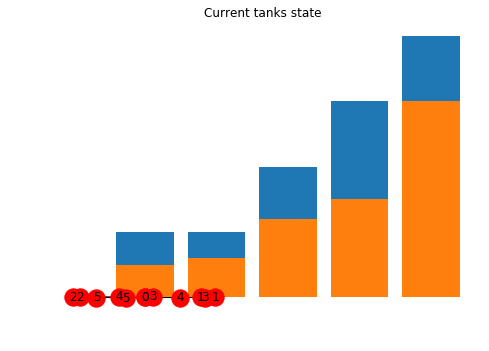

In [3027]:
    index = np.arange(len(tank_ids))
    plt.bar(index, tank_max_loads)
    plt.bar(index, tank_current_loads)
    plt.xlabel('Tank id', fontsize=10)
    plt.ylabel('Current level', fontsize=10)
    plt.xticks(index, tank_ids, fontsize=10, rotation=30)
    plt.title('Current tanks state')
    plt.show()

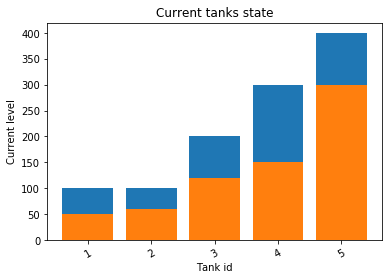

In [3028]:
            index = np.arange(toy_system.n)
            plt.bar(index, toy_system.tank_max_loads())
            plt.bar(index, toy_system.tank_loads())
            plt.xlabel('Tank id', fontsize=10)
            plt.ylabel('Current level', fontsize=10)
            plt.xticks(index, toy_system.tank_ids(), fontsize=10, rotation=30)
            plt.title('Current tanks state')
            plt.show()


#toy_system.visualize()

In [3029]:
# seed = None
# print(toy_system.state())
# rewards = toy_system.random_action(seed)
# print(toy_system.state())
# print("Final rewards: ", rewards)

truck_pos:  3
truck_pos:  0
[[3, 0], [20.0, 50.0], [90.0, 50.0, 110.0, 160.0, 290.0]]
Final rewards:  -100.0


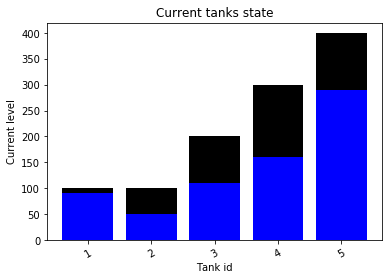

In [3030]:
# Simulation
for it in range(1):
    rewards = toy_system.random_action(seed)
    print(toy_system.state())
    print("Final rewards: ", rewards)
    toy_system.reset_trucks_positions()
    toy_system.visualize()

In [3031]:
toy_system.weights

array([[  0. ,  20. ,  10. ,  30. ,  50.5,  45. ],
       [  inf,   inf,   inf,   inf,   inf,   inf],
       [  inf,   inf,   inf,   inf,   inf,   inf],
       [  inf,   inf,   inf,   inf,   inf,   inf],
       [  inf,   inf,   inf,   inf,   inf,   inf],
       [  inf,   inf,   inf,   inf,   inf,   inf]])

In [3032]:
print(toy_system.graph)

[[1 1 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [3033]:
[trucks[j].load for j in range(k)]

[20.0, 50.0]

In [3034]:
k

2

In [3035]:
truck_current_positions 

array([0, 0])

In [3036]:

trucks[0].possible_delivery_quantities()

TypeError: possible_delivery_quantities() missing 1 required positional argument: 'tank_extra_capacity'

In [ ]:
l = [[1,2,3], [1,2
              ]]

In [ ]:
l


In [ ]:
len(l)

In [ ]:
n_states = toy_system.n_states()

In [ ]:
n_states

In [ ]:
5*5*3*3*5*5*10**3